# ICE exchange feed analysis

In [40]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## FIX/CTF format
The CTF wire protocol is designed for efficient exchange of data and commands between ICE Data Services information products and customers. The protocol enables users of the Client Site Processor (CSP) to receive content from different exchanges using a uniform set of fields

### Filed Order, Length and Descriptions

| **Field name**           | Fram start | Protocol signature | Length (Bytes)                  | Param                              | Delim   | ... | Param                              | Frame end |
|----------------------|------------|--------------------|-----------------------------|------------------------------------|---------|-----|------------------------------------|----------|
| **Field length (bytes)** | 1          | 1                  | 4                           | Variable                           | 1       | ... | Varaiable                          | 1        |
| **Description**                | `0x4`      | `0x20`             | Unsigned long (Big end-ian) | Token-value pair. Delimited,by "=" | `0x7C`  | ... | Token-value pair. Delimited,by "=" | `0x03`   |

## Token lookup

In [2]:
token_lookup = {}

TOKEN_NUMBER = 0
TOKEN_NAME = 1

with open('data/tokens.csv', 'rt') as csvfile:
    r = csv.reader(csvfile, delimiter=';')
    
    for row in r:
        token_lookup[row[TOKEN_NUMBER]] = row[TOKEN_NAME]

# Read FIX file

In [15]:
with open('data/2018-04-26_morning_10min_1_feed.dat', 'r', encoding = "ISO-8859-1") as f:
    read_data = f.read()

Split messages on frame end `0x03`

In [17]:
fix_messages = read_data.split('\x03')

In [32]:
fix_len = []
for f in fix_messages:
    fix_len.append(len(f) + 1)

In [20]:
len(fix_len)

10193231

In [42]:
fix_len = list(zip(fix_messages, fix_len))

In [46]:
fix = pd.DataFrame(data=fix_len, columns=['FIX','LEN'])

In [68]:
fix.LEN.describe()

count    1.019323e+07
mean     1.443948e+02
std      3.405526e+01
min      1.000000e+00
25%      1.480000e+02
50%      1.560000e+02
75%      1.580000e+02
max      1.913000e+03
Name: LEN, dtype: float64

In [83]:
fix.LEN.median()

156.0

In [65]:
fix.loc[4584800].FIX

'\x04 \x00\x00\x07r3=922|4=922|5=.CSP.EXTENDED|437=1524730200|13535=1521699882|13536=35+01:45|13540=20180426081000000|13541=1524730200|13400=34|13403=1523747320.62923|13406=6886933878275|13407=25224826853|13408=27066171802|13409=39401519204|13410=873628939|13411=34840795|13412=195248662940|13413=23907999015|13415=33939169169|13416=398466650|13417=656691976|13418=698246036|13419=6641111|13420=11637409|13421=19254787|13422=4295852954|13423=429584830|13425=476914122|13426=7159747|13427=7948517|13428=13152418|13429=455111050|13430=7585102|13431=11492655|13432=6547736|13433=46449602934|13434=170131326|13435=271904385|13436=935689020|13437=19784641|13438=973823|13439=1013713585|13440=124128191|13442=398148945|13443=2068803|13444=15594817|13445=10407488|13446=34480|13447=173457|13448=512839|13449=69832015|13450=6983194|13452=8313766|13453=116387|13454=138562|13455=481334|13456=6518406|13457=108639|13458=298183|13459=109152|13460=11587599|13461=9|13462=14|13463=32994|13464=13|13465=14|13466=14

In [62]:
fix[fix.LEN == fix.LEN.max()]

,FIX,LEN
4584800,   r3=922|4=922|5=.CSP.EXTENDED|437=15247302...,1913
5949217,   r3=922|4=922|5=.CSP.EXTENDED|437=15247302...,1913


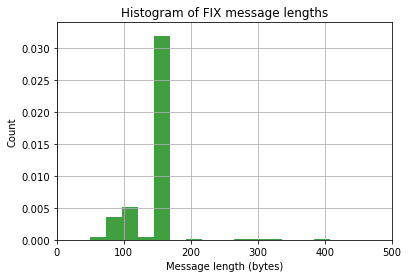

In [82]:
# the histogram of the data
plt.hist(fix.LEN, 80, normed=1, facecolor='green', alpha=0.75)


plt.xlabel('Message length (bytes)')
plt.ylabel('Count')
plt.title('Histogram of FIX message lengths')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 500, 0, 0.034])
plt.grid(True)
plt.show()

### Clean messages

Remove incomplete messages

In [213]:
del fix_messages[-1]

Remove header (*Frame start, Protocol signature and Length*)

In [214]:
remove_header = lambda f: f[6:]
fix_messages = list(map(remove_header, fix_messages))

Split Token values

In [215]:
fix_messages = list(map(lambda f: f.split('|'), fix_messages))

In [216]:
# Generator that splits the token-values in to a tuple and translates tokens number to token name
def lookup_fix(fm):
    def fix_stream():
        for m in fm:
            fix_message = {}
            for tv in m:
                t, v = tuple(tv.split('='))
                fix_message[token_lookup.get(t)] = v
            yield fix_message
    return fix_stream()

In [217]:
fix_messages = lookup_fix(fix_messages)

In [222]:
for f in fix_messages:
    print('SYMBOL.TICKER', f.get('SYMBOL.TICKER'))
    print('QUOTE.DATETIME', f.get('QUOTE.DATETIME'))
    print('BID.PRICE', f.get('BID.PRICE'))
    break

{'BID.PRICE': '260.65', 'QUOTE.DATETIME': '1523363663.77953', 'ACTIVITY.DATETIME': '1523363663.77953', 'BID.SIZE': '2054', 'PERMISSION': '788', 'QUOTE.OFFICIAL.DATE': '20180410', 'DELAY_MINS': '15', 'MID.PRICE': '260.6551', 'SYMBOL.TICKER': 'E:NRGW', 'QUOTE.OFFICIAL.TIME': '123423775831000', 'BID.COUNT': '1', 'ENUM.SRC.ID': '788', 'EXCH.MESSAGE.TIMESTAMP': '123423775878000'}
SYMBOL.TICKER E:NRGW
QUOTE.DATETIME 1523363663.77953
BID.PRICE 260.65


In [180]:
buffer = read_data

from collections import Counter

cnt = Counter()

for fix_message in buffer.split('\x04'):
    #print(fix_message)
    val = fix_message.split('|')
    
    if(len(val[0]) == 0):
        continue
    
    for tv in val:
        try:
            t, v = tv.split('=')
        except (ValueError):
            continue
        
        tn = token_lookup.get(t)
        cnt[tn] += 1
        
        #print(v, '=', tn)
    #print('\n')


In [181]:
print("Total messages", len(buffer.split('\x04')))
for tn, c in cnt.most_common():
    print(c, tn, sep='\t')

Total messages 153695
153693	ENUM.SRC.ID
153693	SYMBOL.TICKER
153692	DELAY_MINS
153692	ACTIVITY.DATETIME
153691	None
153684	EXCH.MESSAGE.TIMESTAMP
149689	QUOTE.OFFICIAL.TIME
149689	QUOTE.OFFICIAL.DATE
149689	QUOTE.DATETIME
148507	MID.PRICE
75307	BID.SIZE
75307	BID.PRICE
75304	BID.COUNT
74385	ASK.COUNT
74385	ASK.SIZE
74385	ASK.PRICE
1411	DYNAMIC.UPPER.LMT
1411	DYNAMIC.LOWER.LMT
389	TRADE.TOTAL.VALUE
389	TRADE.COND_1
389	NOMINAL.VALUE
389	TRADE.VALUE
389	TRADE.DATETIME
389	TRADE.OFFICIAL.DATE
389	MMT.TRADE.OFFICIAL.TIME
389	ORDERBOOK.TRADE.VOL
389	MMT.TRADE.PRICE
389	TRADE.PRICE
389	TRADE.OFFICIAL.TIME
389	MMT.TRADE.UNIQUE.ID
389	EXTENDED.MMID1
389	ORDERBOOK.TRADE.COUNT
389	PCT.CHG
389	ORDERBOOK.TURNOVER
389	TRADE.UNIQUE.ID
389	TRADE.TREND
389	MMT.TRADE.SIZE
389	TRADE.SIZE
389	TRADE.VOL
389	TRADE.TICK
389	PRICE.CODE
389	CHG
389	EXECUTION.VENUE.ID
389	TRADE.COUNT
389	CURRENCY.STRING
389	VWAP
388	TRADE.COND_2
357	MMT.ALGO.TRADE
330	NOMINAL.CURRENCY
16	TRADE.LOW
10	TRADE.HIGH
6	TRADE.BLOCK.

In [73]:
ASRNL = read_data[0:160]

In [74]:
ASRNL_payload = ASRNL[6:-1]

In [108]:
for value in ASRNL_payload.split('|'):
    t, v = value.split('=')
    print(t,v, token_lookup.get(t), sep='\t')

3	788	PERMISSION
4	788	ENUM.SRC.ID
5	E:ASRNL	SYMBOL.TICKER
269	15	DELAY_MINS
211	5	ASK.COUNT
10	37.58	ASK.PRICE
11	788	ASK.SIZE
55	123423768660000	EXCH.MESSAGE.TIMESTAMP
347	37.5488	MID.PRICE
20	1523363663.77077	QUOTE.DATETIME
824	20180410	QUOTE.OFFICIAL.DATE
25	123423768607000	QUOTE.OFFICIAL.TIME
16	1523363663.77077	ACTIVITY.DATETIME
